# Demo 3: Comparison to Scikit-learn

In this demo I build upon the results of Demo 2 to compare my functions' output to those from similar functions in the popular Scikit-learn Python package.

## Package Imports and Initial Setup

In [1]:
import src.coorddescent as cd

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Data Import and Standardization

In [2]:
# import data and drop all rows that contain NA's
hitters = pd.read_csv('./data/Hitters.csv', sep=',', header=0)
hitters = hitters.dropna()

# split out predictors and response
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

# encode the variables League, Division, and NewLeague
X = pd.get_dummies(X, drop_first=True)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale and center predictors
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# scale and center response
y_train_mean = np.mean(y_train)
y_train_sd = np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_sd
y_test = (y_test - y_train_mean) / y_train_sd

# save dimensions of training and test sets
n_train, p_train = X_train.shape
n_test, p_test = X_test.shape;

## Comparing Cross-Validation Results

As shown in Demo 2, my functions' cross-validation yields an optimal $\lambda$ value of 0.01 on the training set. Using this to train my model yields the following coefficients for my cyclic and random coordinate descent algorithms:

In [3]:
alpha = 0.9
best_lam = 0.01
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, best_lam, alpha, desc_type="random", random_seed=0)
betas_cyclic[-1]
betas_random[-1]

array([-0.52875831,  0.56018528,  0.11625246, -0.0465287 ,  0.00600779,
        0.28440328, -0.09481342,  0.        ,  0.35787561,  0.        ,
        0.47990408,  0.        , -0.3809565 ,  0.1439146 ,  0.06942123,
       -0.07046832,  0.02864446, -0.12395357,  0.        ])

array([-0.52875344,  0.5601743 ,  0.11625262, -0.04652008,  0.00600744,
        0.28440197, -0.09481677,  0.        ,  0.35791176,  0.        ,
        0.47986391,  0.        , -0.38094912,  0.14391389,  0.06942123,
       -0.0704692 ,  0.02864398, -0.12395445,  0.        ])

Scikit-learn's `ElasticNetCV` performs similar cross-validation. However, when I fit the same data as above to the `ElasticNetCV` model I get quite different coefficients from my results, as shown below.

In [4]:
en = ElasticNetCV(l1_ratio=alpha)
en.fit(X_train, y_train)
print("scikit-learn coefficients: \n" + str(en.coef_))
print("\nscikit-learn best regularization parameter = " + str(en.alpha_));

scikit-learn coefficients: 
[ 0.          0.17937785  0.02409647  0.          0.0329384   0.10170979
  0.          0.          0.24929953  0.          0.14171223  0.          0.
  0.09084651 -0.         -0.00729358  0.         -0.08102662  0.        ]

scikit-learn best regularization parameter = 0.0542624812716


This regularization parameter is close, but not identical to that which I found through my own cross-validation. However, what stands out more is the differences in the coefficients -- the Scikit-learn model generates quite different results, including a fair bit more zero coefficients than my model. The coefficients for the three methods are visualized below.

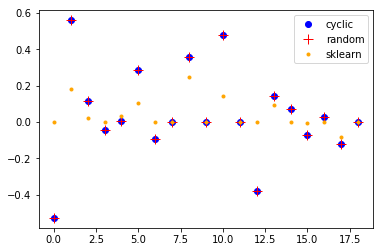

In [5]:
plt.plot(betas_cyclic[-1], '.', color='blue', ms=12)
plt.plot(betas_random[-1], '+', color='red', ms=10)
plt.plot(en.coef_, '.', color='orange');
plt.legend(['cyclic','random','sklearn'], loc=1);

However, it would be unwise to jump to conclusions about coefficient differences between models since they were trained using different regularization parameters.

Thus, I fit my models using the same regularization parameter as Scikit-learn found through its cross-validation to see if I can get the coefficients to match. The results for the three methods are printed and visualized below.

In [6]:
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, en.alpha_, alpha, desc_type="cyclic")
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, en.alpha_, alpha, desc_type="random", random_seed=0)
betas_cyclic[-1]
betas_random[-1]
en.coef_

array([ 0.        ,  0.20098401,  0.04289204,  0.        ,  0.01495403,
        0.11577147,  0.        ,  0.        ,  0.31903656,  0.        ,
        0.08805677,  0.        ,  0.        ,  0.10635379,  0.        ,
       -0.03914407,  0.00803714, -0.10693343,  0.        ])

array([ 0.        ,  0.20098401,  0.04289204,  0.        ,  0.01495403,
        0.11577147,  0.        ,  0.        ,  0.31903655,  0.        ,
        0.08805677,  0.        ,  0.        ,  0.10635379,  0.        ,
       -0.03914407,  0.00803714, -0.10693343,  0.        ])

array([ 0.        ,  0.17937785,  0.02409647,  0.        ,  0.0329384 ,
        0.10170979,  0.        ,  0.        ,  0.24929953,  0.        ,
        0.14171223,  0.        ,  0.        ,  0.09084651, -0.        ,
       -0.00729358,  0.        , -0.08102662,  0.        ])

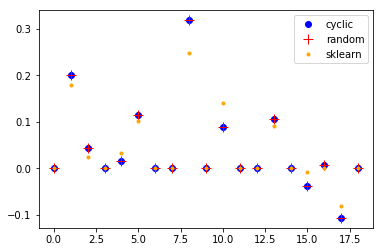

In [7]:
plt.plot(betas_cyclic[-1], '.', color='blue', ms=12)
plt.plot(betas_random[-1], '+', color='red', ms=10)
plt.plot(en.coef_, '.', color='orange');
plt.legend(['cyclic','random','sklearn'], loc=1);

We see that the results are much closer this time, including a close match on which coefficients are zero or not. However, the magnitudes are still not as close as we might like. So what's going on here?

It turns out the discrepancies are due to differences in the objective functions used between the two approaches. The objective function I used had a 1/n term out front, whereas the Scikit-learn function uses 1/2n. The function is minimized the same either way; the 1/2n is used to make the subgradient and soft-thresholding operator calculations a little cleaner.

Accounting for the difference, I have included an argument in my functions to make my output match that of Scikit-learn. The only difference is, again, a factor of 2 in the denominator of the soft-thresholding operator.

Fitting my models with `match_skl=True` yields results that are essentially a spot-on match with Scikit-learn.

In [8]:
betas_cyclic = cd.coorddescent(np.zeros(p_train), X_train, y_train, en.alpha_, alpha, desc_type="cyclic", match_skl=True)
betas_random = cd.coorddescent(np.zeros(p_train), X_train, y_train, en.alpha_, alpha, desc_type="random", random_seed=0, match_skl=True)
betas_cyclic[-1]
betas_random[-1]
en.coef_

array([ 0.        ,  0.17937025,  0.02399085,  0.        ,  0.03304672,
        0.10164375,  0.        ,  0.        ,  0.24861867,  0.        ,
        0.14239681,  0.        ,  0.        ,  0.09086728,  0.        ,
       -0.0072833 ,  0.        , -0.08100263,  0.        ])

array([ 0.        ,  0.17937025,  0.02399085,  0.        ,  0.03304672,
        0.10164375,  0.        ,  0.        ,  0.24861867,  0.        ,
        0.14239681,  0.        ,  0.        ,  0.09086728,  0.        ,
       -0.0072833 ,  0.        , -0.08100263,  0.        ])

array([ 0.        ,  0.17937785,  0.02409647,  0.        ,  0.0329384 ,
        0.10170979,  0.        ,  0.        ,  0.24929953,  0.        ,
        0.14171223,  0.        ,  0.        ,  0.09084651, -0.        ,
       -0.00729358,  0.        , -0.08102662,  0.        ])

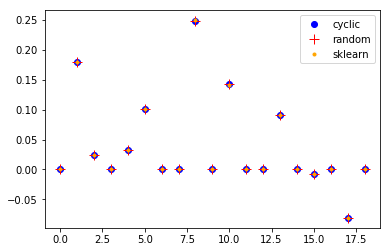

In [9]:
plt.plot(betas_cyclic[-1], '.', color='blue', ms=12)
plt.plot(betas_random[-1], '+', color='red', ms=10)
plt.plot(en.coef_, '.', color='orange');
plt.legend(['cyclic','random','sklearn'], loc=1);

So there you have it! An important takeaway from this Demo is that you should always know what objective function is being minimized when you use a built-in machine learning algorithm.